In [25]:

## Libraries

from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt


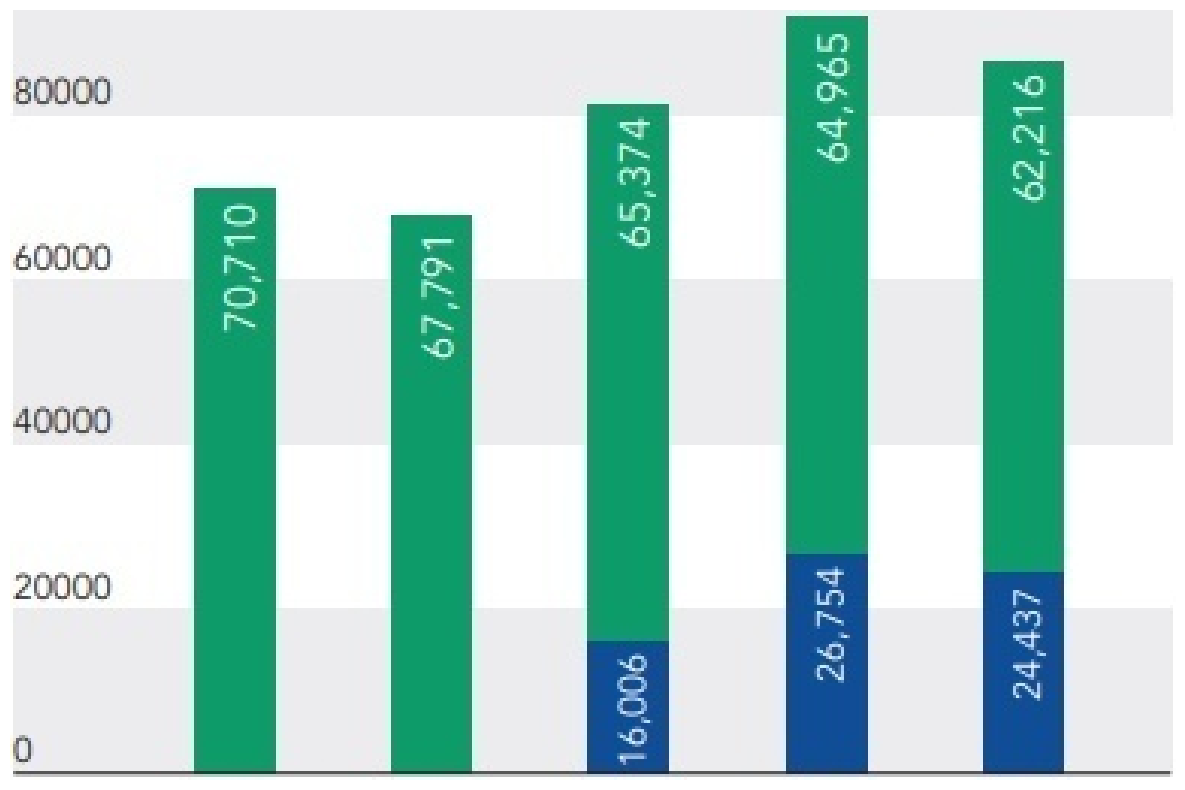

In [26]:

## Read and display the image

imgFile = "stamp_1.jpg"
img = cv2.imread(imgFile)

def imshow(img, showAxis = False, size=(20,10)):
    plt.figure(figsize=size)
    if not showAxis: plt.axis('off')
    if len(img.shape) == 3: plt.imshow(img[:,:,::-1])
    else: plt.imshow(img, cmap='gray')
    
imshow(img)


In [27]:
img 

array([[[255, 255, 255],
        [236, 236, 236],
        [238, 236, 236],
        ...,
        [238, 236, 236],
        [236, 236, 236],
        [255, 255, 255]],

       [[255, 255, 255],
        [236, 236, 236],
        [238, 236, 236],
        ...,
        [238, 236, 236],
        [236, 236, 236],
        [255, 255, 255]],

       [[255, 255, 255],
        [236, 236, 236],
        [238, 236, 236],
        ...,
        [238, 236, 236],
        [236, 236, 236],
        [255, 255, 255]],

       ...,

       [[255, 255, 254],
        [124, 125, 123],
        [ 83,  88,  87],
        ...,
        [ 86,  86,  86],
        [192, 192, 192],
        [254, 254, 254]],

       [[253, 251, 250],
        [210, 211, 209],
        [190, 192, 192],
        ...,
        [193, 193, 193],
        [237, 237, 237],
        [255, 255, 255]],

       [[252, 253, 251],
        [255, 255, 254],
        [254, 254, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

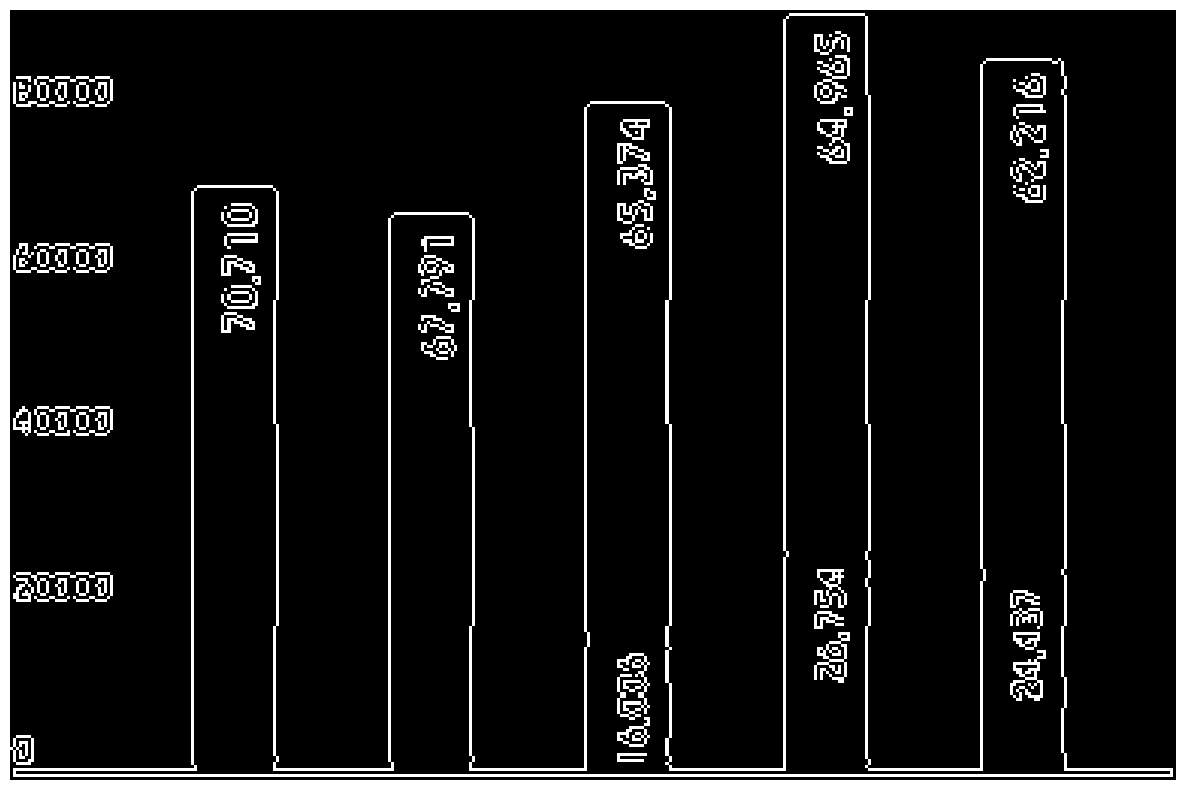

In [28]:

## Blur & detect the edges

# Convert to Grayscale
gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

# Blur to remove noise
blur = cv2.bilateralFilter(gray.copy(), 15, 15, 15 )

# Find edges using canny edge detector
def auto_canny(grayim, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(grayim)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(grayim, lower, upper)
    # return the edged image
    return edged

# Find the edges and display the image
edged = auto_canny(blur)
imshow(edged)


In [29]:

## Find Contours

# detect the contours on the binary image
contours, _ = cv2.findContours(image=edged.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
print(f'Total nr of contours found: {len(contours)}')

# Sort Contours by Area and get topN
topN = 10
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)                     
sorted_contours = sorted_contours[:topN]

Total nr of contours found: 28


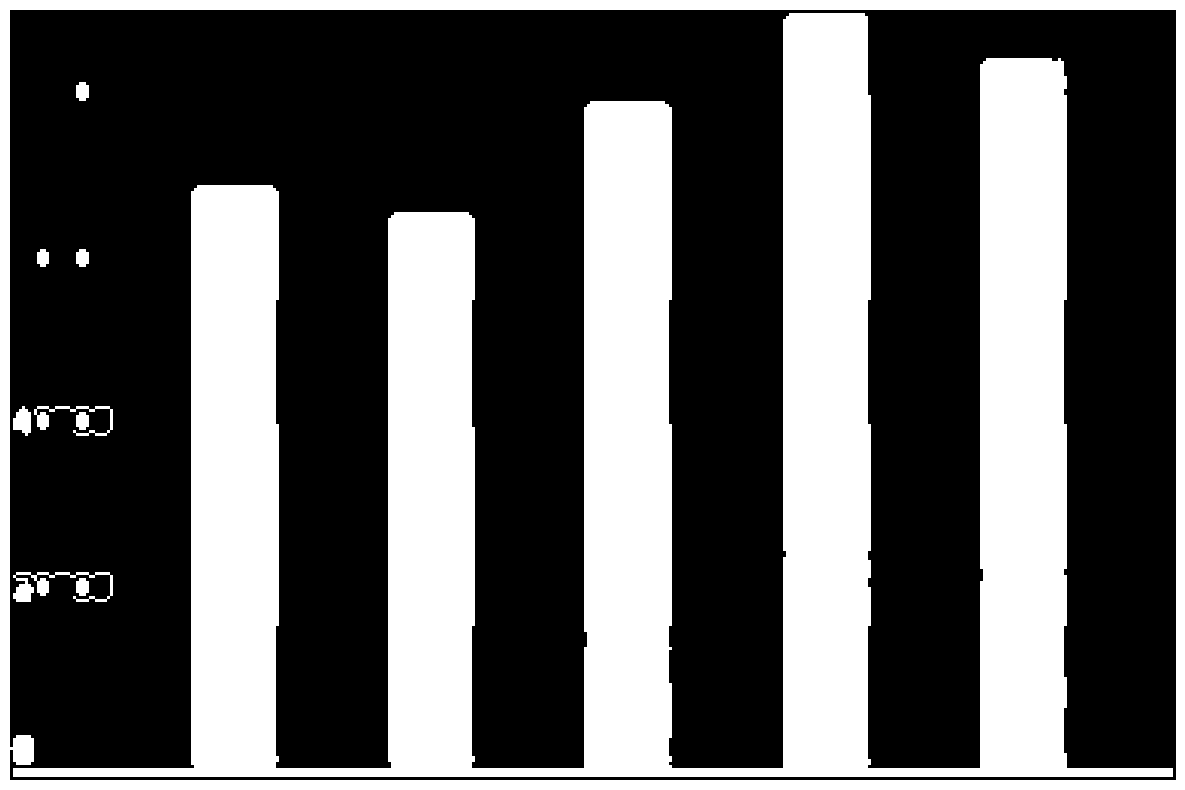

In [30]:

##  Fill the area inside contours
filteredCircle = np.zeros((img.shape[:2]), dtype =np.uint8)
# cv2.drawContours(image=filteredCircle, contours=sorted_contours, contourIdx=-1, color=(255, 255, 255), thickness=cv2.FILLED)
cv2.drawContours(image=filteredCircle, contours=sorted_contours, contourIdx=-1, color=(255, 255, 255), thickness=cv2.FILLED)
imshow(filteredCircle)

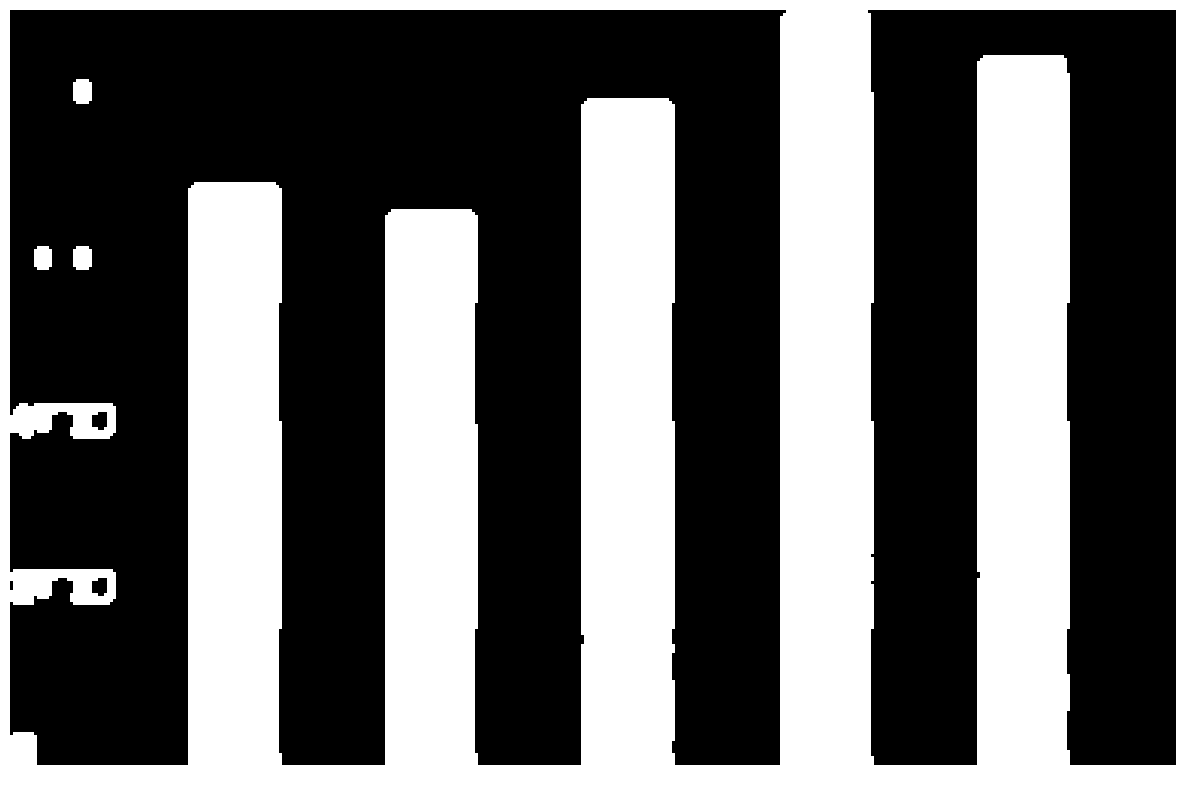

In [31]:

## Close Blobs

kernel = np.ones((3,3),np.uint8)
closedCircle = cv2.morphologyEx(filteredCircle, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, kernel, iterations=1)
imshow(closedCircle)

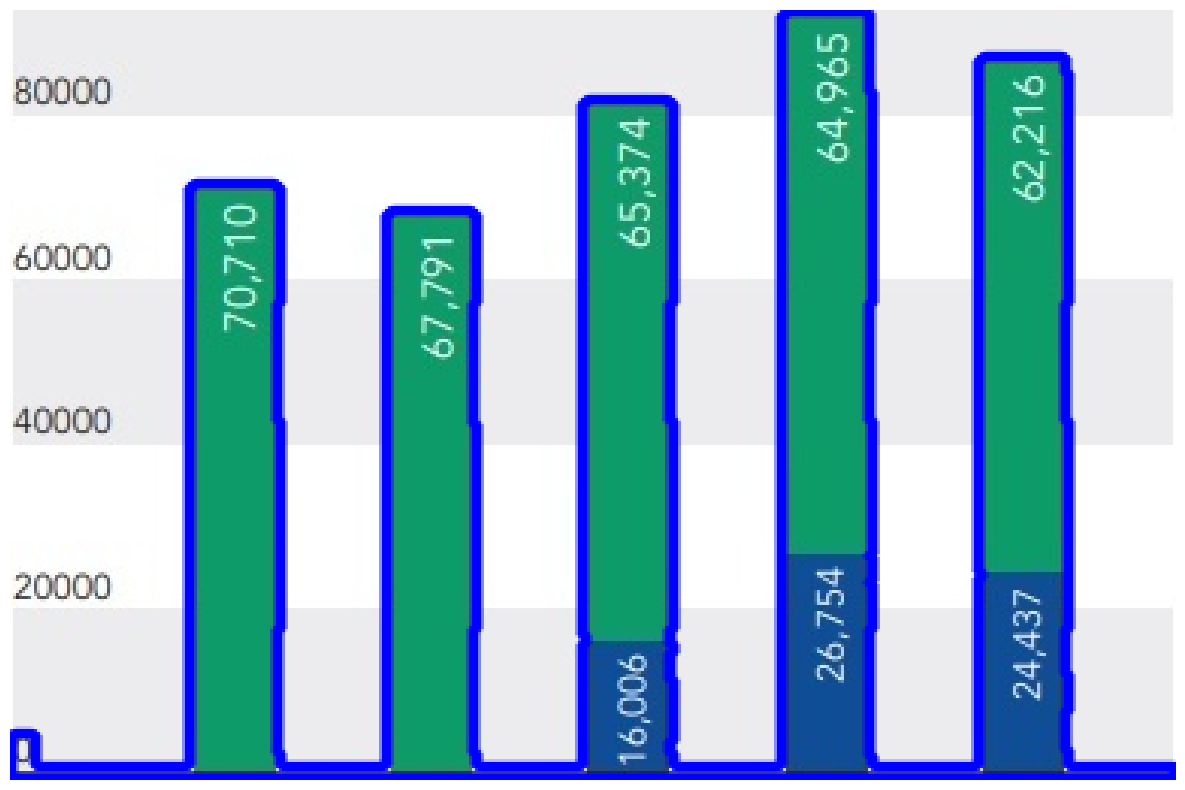

In [32]:

## Filter Stamps

# Find contours from the processed binary image
filteredContours, _ = cv2.findContours(image=closedCircle.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

# Identify only contours with more than 5 points
circleContours = []
for index, contour in enumerate(filteredContours):
    perimeter = cv2.arcLength(contour,True)
    approxPoints = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
    if len(approxPoints) > 7: 
        circleContours.append(contour)

# Display the identified stamps
out = img.copy()
cv2.drawContours(image=out, contours=circleContours, contourIdx=-1, color=(255,0, 0), thickness=2, lineType=cv2.LINE_AA)
imshow(out)

In [33]:
# Iterate through the identified stamp contours and crop the corresponding portions from the image
cropped_stamps = []

for contour in circleContours:
    # Get the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Crop the region of interest (ROI) from the original image
    stamp_roi = img[y:y+h, x:x+w]
    
    # Append the cropped stamp to the list
    cropped_stamps.append(stamp_roi)

stamp_array = []
# Display or save the cropped stamp images
for i, stamp in enumerate(cropped_stamps):
    stamp_array.append(stamp)
    cv2.imshow(f'Stamp {i+1}', stamp)
    cv2.imwrite(f'stamp_{i+1}.jpg', stamp)

# Optionally, display the original image with stamp contours
out = img.copy()
cv2.drawContours(image=out, contours=circleContours, contourIdx=-1, color=(255, 0, 0), thickness=2, lineType=cv2.LINE_AA)
cv2.imshow('Image with Contours', out)

cv2.waitKey(0)
cv2.destroyAllWindows()


In [34]:
def countStamps(contour : list):
    return len(contour)

countStamps(circleContours)
circleContours[0]


array([[[257,   0]],

       [[256,   1]],

       [[255,   2]],

       ...,

       [[260,   0]],

       [[259,   0]],

       [[258,   0]]], dtype=int32)

In [35]:
#return min max 

import numpy as np

# Your contour data
contour = np.array([[[181, 515]], [[180, 516]], [[179, 516]]], dtype=np.int32)  # Replace with your contour data

x_min = float('inf')
x_max = -float('inf')
y_min = float('inf')
y_max = -float('inf')

for point in circleContours[0]:
    x, y = point[0]  # Extract x and y coordinates
    if x < x_min:
        x_min = x
        x_min_y = y
    if x > x_max:
        x_max = x
        x_max_y = y
    if y < y_min:
        y_min = y
        y_min_x = x
    if y > y_max:
        y_max = y
        y_max_x = x

result = [(x_min, x_min_y), (x_max, x_max_y), (y_min_x, y_min), (y_max_x, y_max)]

print(result)


[(0, 240), (385, 254), (257, 0), (0, 254)]


finding the image with contour

In [36]:
# stamp = img[result[0][0]:result[1][0], result[2][1]: result[3][1]]
# imshow(stamp)

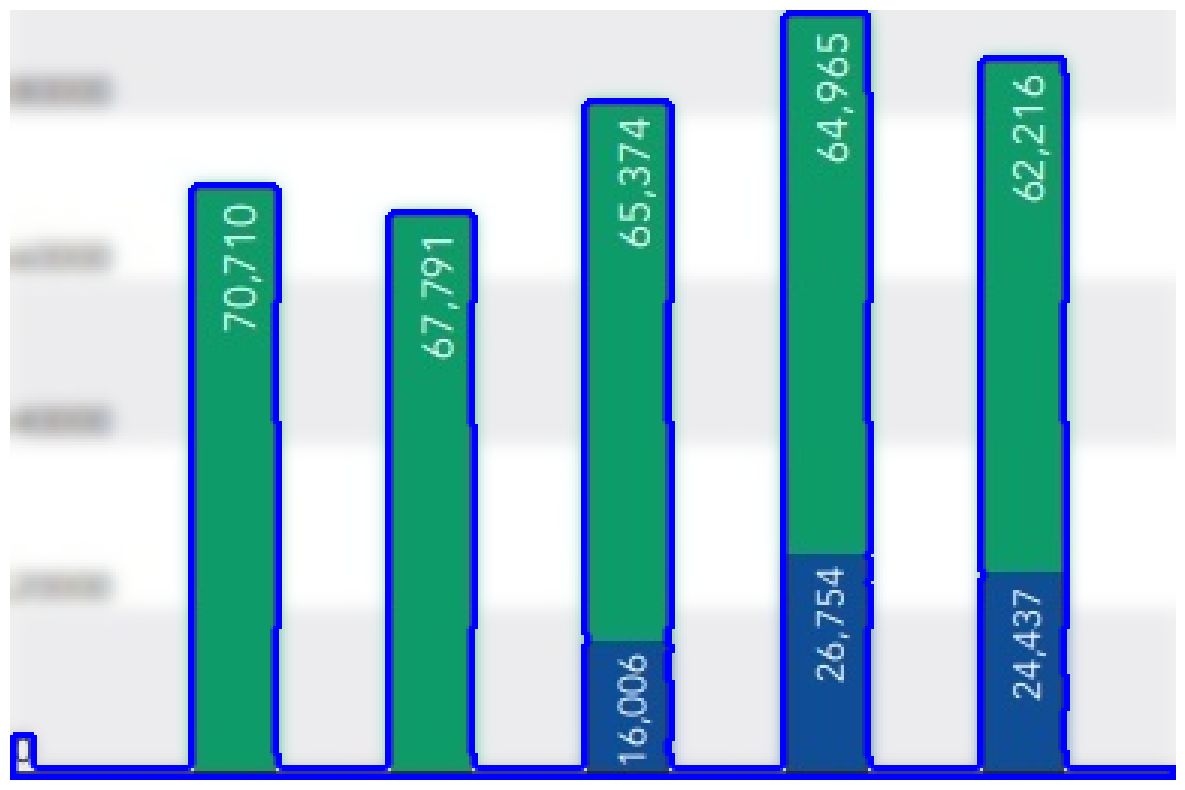

In [37]:

# Highlight the stamped region

# Import
from itertools import product

# Blur the image
highlight_blur = cv2.GaussianBlur(img.copy(), (15,15),0)

# Loop through every point in the image
for y, x in product(range(img.shape[0]), range(img.shape[1])):
    # Loop through all the contours
    for contour in circleContours:
        # Check if the point is on or inside the contour
        if cv2.pointPolygonTest(contour, [x, y], False) >= 0.0:
            # Replace the image with the output image
            highlight_blur[y, x, :] = out[y, x, :]

imshow(highlight_blur)

In [38]:
from PIL import Image
import pytesseract
import json

# Load the image
# image = Image.open('assets\Screenshot 2023-10-25 154133.png')
image = Image.open('stamp_1.jpg')
# image = Image.open('result_image.jpg')
image = image.convert('L')
image = image.rotate(-90, expand=True)
image.show()
# 
# Rotate the image by 90 degrees (counter-clockwise) to make vertical text horizontal
# rotated_image = image.rotate(90, expand=True)

# Use OCR to extract text from the rotated image
extracted_text = pytesseract.image_to_string(image)

# Process the extracted text to create a JSON output (same as in the previous code)

data = {}

# Split the text into line
lines = extracted_text.split('\n')
lines

# # Extract x-axis (years) and y-axis (keys and values)
# x_axis = lines[0].split()[1:]  # Assuming the years are on the first line
# y_data = {}
# for line in lines[1:]:
#     parts = line.split()
#     key = parts[0]  # Assuming the first word is the key
#     values = [int(value) for value in parts[1:]]  # Assuming the values start from the second word
#     y_data[key] = values

# # Create the JSON output (same as in the previous code)

# for year, values in zip(x_axis, zip(*y_data.values())):
#     data[year] = {key: value for key, value in zip(y_data.keys(), values)}

# # Save the JSON output to a file or return it as needed
# with open('output.json', 'w') as json_file:
#     json.dump(data, json_file, indent=4)

# # Print the JSON output
# print(json.dumps(data, indent=4))


['0009', '0008', '']

In [39]:
import cv2
import numpy as np

# Load the image where you want to crop the bars
image = cv2.imread('your_image.jpg')

# Define the coordinates of the region to crop based on the contour
x, y, w, h = cv2.boundingRect(stamp_array[0])

# Crop the region from the image
cropped_image = image[y:y+h, x:x+w]

# Display or save the cropped image
cv2.imshow('Cropped Image', cropped_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Save the cropped image as a PNG
cv2.imwrite('cropped_image.png', cropped_image)


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\shapedescr.cpp:1044: error: (-215:Assertion failed) img.depth() <= CV_8S && img.channels() == 1 in function 'cv::maskBoundingRect'
